# Hybrid Controlled Invariant Set


## Introduction

This example considers the hybrid constrained linear control system:
$$
\begin{aligned}
\dot{x}_1(t) & = x_2(t)\\
\dot{x}_2(t) & = u(t)
\end{aligned}
$$
with state constraint $x \in [-1, 1]^2$ and input constraint $u \in [-1, 1]$
and the jump:
$$
\begin{aligned}
x_1^+ & = -x_1 + u/8\\
x_2^+ & = x_2 - u/8
\end{aligned}
$$
with state constraint $x \in [-1, 1]^2$ and input constraint $u \in [-1, 1]$
that can occur anytime.

In order to compute controlled invariant sets for this system, we consider
the projection onto the first two dimensions of controlled invariant sets of the
following lifted system:
$$
\begin{aligned}
\dot{x}_1(t) & = x_2(t)\\
\dot{x}_2(t) & = x_3(t)\\
\dot{x}_3(t) & = u(t)
\end{aligned}
$$
with state constraint $x \in [-1, 1]^3$;
with a first jump to a temporary mode:
$$
\begin{aligned}
x_1^+ & = x_1\\
x_2^+ & = x_2\\
x_3^+ & = u
\end{aligned}
$$
with state constraint $x \in [-1, 1]^3$ and unconstrained input;
and a second jump back to the original mode:
$$
\begin{aligned}
x_1^+ & = -x_1 + x_3/8\\
x_2^+ & = x_2 - x_3/8\\
x_3^+ & = u.
\end{aligned}
$$
Note that the input `u` chosen in the first jump is the input that will be used for
the reset map and the input `u` chosen for the second jump is the input that will be used
for the state `x_3` of the continuous-time system.

The matricial form of this system is given by $\dot{x}(t) = Ax(t) + Bu(t)$ where `A` and `B` are as defined below.
As shown in Proposition 5 of [LJ21], a set is controlled invariant for this system if and only if it is weakly invariant for the algebraic system
$$
\begin{aligned}
\dot{x}_1(t) & = x_2(t)\\
\dot{x}_2(t) & = x_3(t)
\end{aligned}
$$
with state constraint $x \in [-1, 1]^3$;
with a first jump to a temporary mode:
$$
\begin{aligned}
x_1^+ & = x_1\\
x_2^+ & = x_2
\end{aligned}
$$
with state constraint $x \in [-1, 1]^3$
and a second jump back to the original mode:
$$
\begin{aligned}
x_1^+ & = -x_1 + x_3/8\\
x_2^+ & = x_2 - x_3/8.
\end{aligned}
$$

The matricial form of this system is given by $E\dot{x}(t) = Cx(t)$ with a first jump
$Ex^+ = Ex$ and a second jump $Ex^+ = Ux$ where:

[LJ21] B. Legat and R. M. Jungers.
*Continuous-time controlled invariant sets, a geometric approach*.
7th IFAC Conference on Analysis and Design of Hybrid Systems ADHS 2021, **2021**.

In [1]:
A = [0.0 1.0 0.0
     0.0 0.0 1.0
     0.0 0.0 0.0]
B = reshape([0.0, 0.0, 1.0], 3, 1)
E = [1.0 0.0 0.0
     0.0 1.0 0.0]
C = A[1:2, :]
U = [-1.0  0.0  1/4
      0.0  1.0 -1/4]

using SetProg
function maximal_invariant(family, γ = nothing; dirs=dirs)
    model = Model(sdp_solver)
    @variable(model, S, family)
    @constraint(model, S ⊆ □_3)
    @variable(model, T, family)
    @constraint(model, T ⊆ □_3)
    x = boundary_point(S, :x)
    @constraint(model, C * x in E * tangent_cone(S, x))
    @constraint(model, E * S ⊆ E * T)
    @constraint(model, U * T ⊆ E * S)
    S_2 = project(S, 1:2)
    if γ === nothing
        @variable(model, γ)
    end
    @constraint(model, [point in dirs], γ * point in S_2)
    @objective(model, Max, γ)
    JuMP.optimize!(model)
    @show solve_time(model)
    @show JuMP.termination_status(model)
    @show JuMP.objective_value(model)
    if JuMP.termination_status(model) == MOI.OPTIMAL
        return JuMP.value(S), JuMP.objective_value(model)
    else
        return
    end
end

import GLPK
lp_solver = optimizer_with_attributes(GLPK.Optimizer, MOI.Silent() => true, "presolve" => GLPK.GLP_ON)
import CSDP
sdp_solver = optimizer_with_attributes(CSDP.Optimizer, MOI.Silent() => true)
using Polyhedra
interval = HalfSpace([1.0], 1.0) ∩ HalfSpace([-1.0], 1.0)
lib = Polyhedra.DefaultLibrary{Float64}(lp_solver)
□_2 = polyhedron(interval * interval, lib)
□_3 = □_2 * interval
u_max = 1/8
x2l0 = √(2u_max) - u_max
dirs = [[-1 + √3, -1 + √3], [-1/2, 1.0], [-1.0, x2l0]]
all_dirs = [dirs; (-).(dirs)]
inner = polyhedron(vrep(all_dirs), lib)
outer = polar(inner)

Polyhedron DefaultPolyhedron{Float64, Polyhedra.Intersection{Float64, Vector{Float64}, Int64}, Polyhedra.Hull{Float64, Vector{Float64}, Int64}}:
6-element iterator of HalfSpace{Float64, Vector{Float64}}:
 HalfSpace([0.7320508075688772, 0.7320508075688772], 1.0)
 HalfSpace([-0.5, 1.0], 1.0)
 HalfSpace([-1.0, 0.375], 1.0)
 HalfSpace([-0.7320508075688772, -0.7320508075688772], 1.0)
 HalfSpace([0.5, -1.0], 1.0)
 HalfSpace([1.0, -0.375], 1.0)

## Ellipsoidal template

We start with the ellipsoidal template. The objective consider is to maximize `γ`
such that `γ * inner` is included in the set.

In [2]:
sol_ell, γ_ell = maximal_invariant(Ellipsoid(symmetric=true))

using Plots
function hexcolor(rgb::UInt32)
    r = ((0xff0000 & rgb) >> 16) / 255
    g = ((0x00ff00 & rgb) >>  8) / 255
    b = ((0x0000ff & rgb)      ) / 255
    Plots.RGBA(r, g, b)
end # Values taken from http://www.toutes-les-couleurs.com/code-couleur-rvb.php
lichen = hexcolor(0x85c17e)
canard = hexcolor(0x048b9a)
aurore = hexcolor(0xffcb60)
frambo = hexcolor(0xc72c48)
cols = [canard, frambo]

x2 = range(0, stop=1, length=20)
x1 = 1 .- x2.^2 / 2
x2l = range(x2l0, stop=1.0 - u_max, length=20)
x1l = -(1 .- (x2l .+ u_max).^2 / 2 .+ u_max)
upper = [[[-1/2, 1.0]]; [[x1l[i], x2l[i]] for i in eachindex(x2l)]; [[x1[i], x2[i]] for i in eachindex(x2)]]
mci = polyhedron(vrep([upper; (-).(upper)]), lib)
polar_mci = polar(mci)

SetProg.Sets.print_support_function(project(sol_ell, 1:2))

solve_time(model) = 0.02475118637084961
JuMP.termination_status(model) = MathOptInterface.OPTIMAL
JuMP.objective_value(model) = 0.8944271817966903
h(S, x) = x[1]^2 + x[2]^2


We can plot the primal solution as follows:

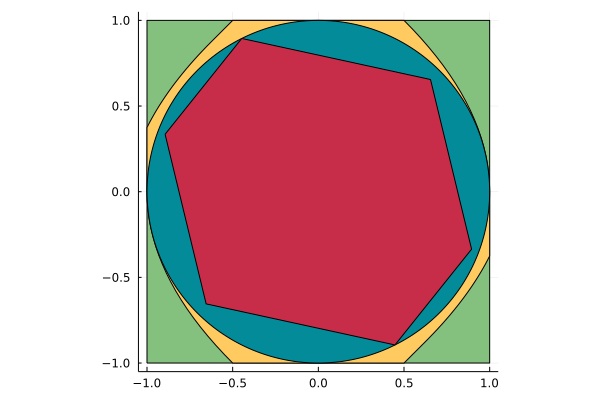

In [3]:
function primal_plot(set, γ=nothing; npoints=256, xlim=(-1.05, 1.05), ylim=(-1.05, 1.05), args...)
    plot(ratio=:equal, tickfont=Plots.font(12); xlim=xlim, ylim=ylim, args...)
    plot!(□_2, color=lichen)
    plot!(mci, color=aurore)
    plot!(set, color=canard, npoints=npoints)
    γ === nothing || plot!(γ * inner, color=frambo)
    plot!()
end
primal_plot(project(sol_ell, 1:2), γ_ell)

and the dual plot as follows:

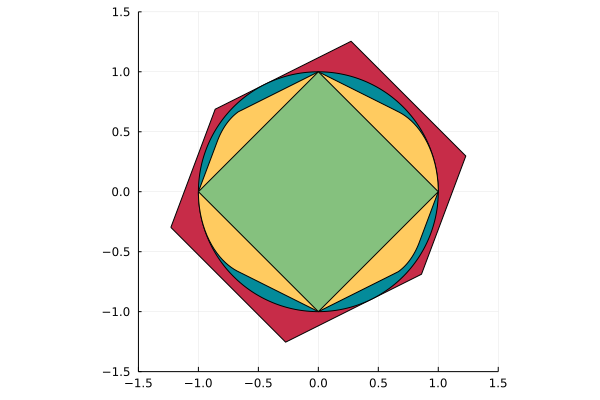

In [4]:
function polar_plot(set, γ; npoints=256, xlim=(-1.5, 1.5), ylim=(-1.5, 1.5), args...)
    plot(ratio=:equal, tickfont=Plots.font(12); xlim=xlim, ylim=ylim, args...)
    γ === nothing || plot!(inv(γ) * outer, color=frambo)
    plot!(polar(set), color=canard, npoints=npoints)
    plot!(polar_mci, color=aurore)
    plot!(polar(□_2), color=lichen)
end
polar_plot(project(sol_ell, 1:2), γ_ell)

## Polyset template

We start with quartic polynomials:

In [5]:
p4, γ4 = maximal_invariant(PolySet(symmetric=true, degree=4, convex=true), 0.896)
γ4

solve_time(model) = 0.1418299674987793
JuMP.termination_status(model) = MathOptInterface.OPTIMAL
JuMP.objective_value(model) = 0.896


0.896

Below is the primal plot:

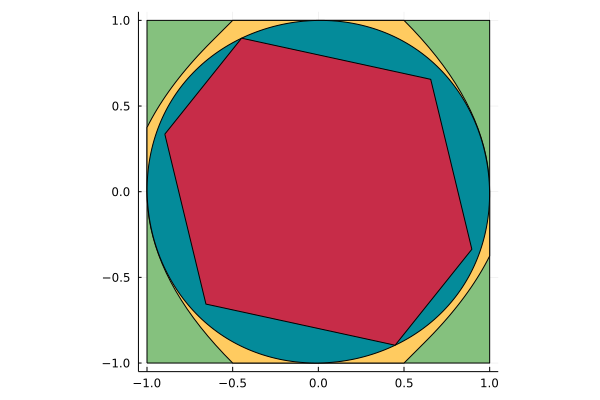

In [6]:
primal_plot(project(p4, 1:2), γ4)

and here is the polar plot:

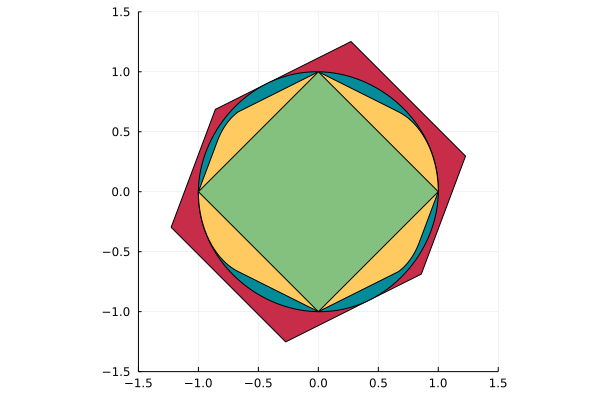

In [7]:
polar_plot(project(p4, 1:2), γ4)

We now try it with sextic polynomials:

In [8]:
p6, γ6 = maximal_invariant(PolySet(symmetric=true, degree=6, convex=true), 0.93)
γ6

solve_time(model) = 0.22344398498535156
JuMP.termination_status(model) = MathOptInterface.OPTIMAL
JuMP.objective_value(model) = 0.93


0.93

Below is the primal plot:

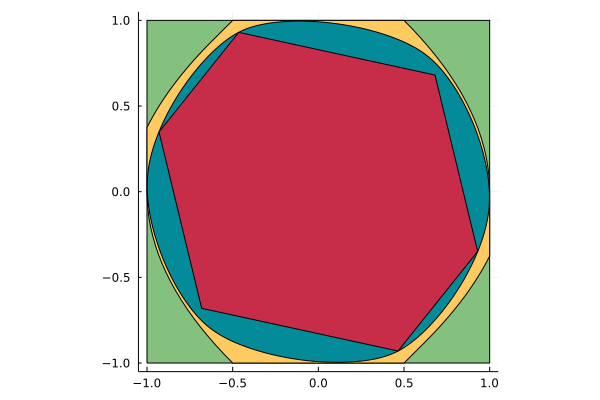

In [9]:
primal_plot(project(p6, 1:2), γ6)

and here is the polar plot:

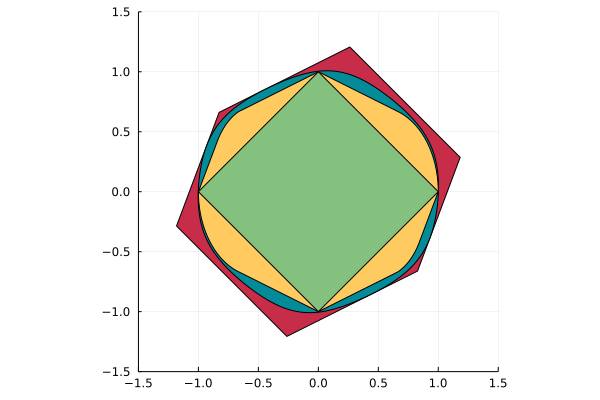

In [10]:
polar_plot(project(p6, 1:2), γ6)

We now try it with octic polynomials:

In [11]:
p8, γ8 = maximal_invariant(PolySet(symmetric=true, degree=8, convex=true), 0.96)
γ8

solve_time(model) = 1.3204588890075684
JuMP.termination_status(model) = MathOptInterface.OPTIMAL
JuMP.objective_value(model) = 0.96


0.96

Below is the primal plot:

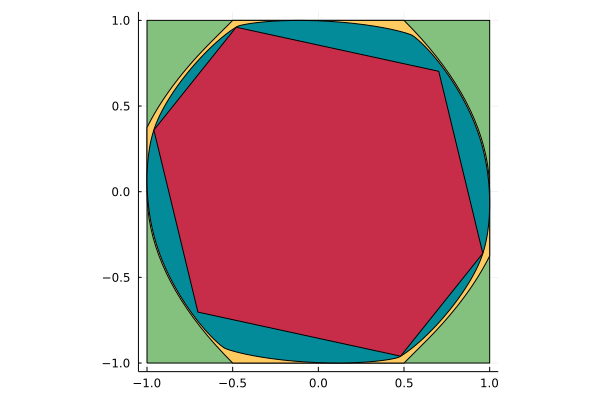

In [12]:
primal_plot(project(p8, 1:2), γ8)

and here is the polar plot:

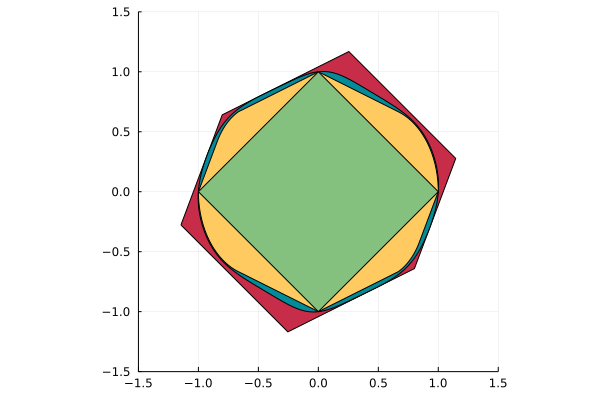

In [13]:
polar_plot(project(p8, 1:2), γ8)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*